# 08 Profit of future with preparation of data

## Tomek Undersampling 

To remove the data with dominating y-values sign (negative PoF for this case) that "next to" the opposing sign (positive PoF).

The definition of "next to" is based on the input value, which is the same as time of the data record.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from util import *
from nbeat import *

bnb_data = pd.read_csv('data/BNBUSDT_1D_2.csv')
bnb_close_values = bnb_data['Close']

In [2]:
future_period = 21
profit_of_future_log = covertToLogScale(computeProfitOfFuture(bnb_close_values, future_period))

skip_count = 390

input_data = np.array(bnb_data['Close'][skip_count:-future_period])
output_data = profit_of_future_log[skip_count:]

dataSize = len(input_data)
assert(dataSize == len(output_data))
windowSize = future_period * 2 # TODO:
testSize = round(dataSize * 0.3)
print(f"dataSize: {dataSize}")
print(f"windowSize: {windowSize}")
print(f"testSize: {testSize}")

input_scale = np.max(input_data)
output_scale = np.max(profit_of_future_log)
print(f"input_scale: {input_scale}")
print(f"output_scale: {output_scale}")


dataSize: 1010
windowSize: 42
testSize: 303
input_scale: 676.967
output_scale: 5.841402995389024


In [3]:
x_train = prepareTrainingInputs(input_data, windowSize, testSize)
y_train = prepareTraingingOutputs(output_data, windowSize, testSize)
x_test = prepareTestingInputs(input_data, windowSize, testSize)
y_test = prepareTestingOutputs(output_data, testSize)

print(f"positive y_train: {len(y_train[y_train > 0])}")
print(f"negative y_train: {len(y_train[y_train < 0])}")
print(f"positive y_test: {len(y_test[y_test > 0])}")
print(f"negative y_test: {len(y_test[y_test < 0])}")


positive y_train: 311
negative y_train: 354
positive y_test: 124
negative y_test: 179


In [4]:
# resample data pair so that the amount of positive y_train would be the same as negative
def undersampleSeriesDataTomekBySign(x, y):
  dataCount = len(y)
  assert(dataCount == len(x))
  # get the amount of positive and negative samples
  posDeterminer = lambda v: v > 0
  negDeterminer = lambda v: v < 0
  posCount = len(y[posDeterminer(y)])
  negCount = len(y[negDeterminer(y)])
  if (posCount == negCount):
    return x, y
  isFilteringPosCount = posCount > negCount
  if isFilteringPosCount:
    filteringDeterminer = posDeterminer
  else:
    filteringDeterminer = negDeterminer
  # undersample the data with determiner until the amount of positive and negative samples are the same
  lastIndex = 0
  while posCount != negCount:
    # get the index of the first element that should be filtered, and it is next to another index that should not be filtered
    index = next((i+lastIndex for i, yy in enumerate(y[lastIndex:]) if (filteringDeterminer(yy) and (
      (not filteringDeterminer(y[max(0, i+lastIndex-1)])) or (not filteringDeterminer(y[min(dataCount-1, i+lastIndex+1)]))
    ))), None)
    if index is None:
      if (lastIndex == 0):
        raise Exception("No element can be filtered")
      lastIndex = 0
      continue
    # remove the element at the index
    x = np.delete(x, index, axis=0)
    y = np.delete(y, index, axis=0)
    # update the counters
    if isFilteringPosCount:
      posCount -= 1
    else:
      negCount -= 1
    dataCount -= 1
    lastIndex = index
    # avoid removing same group again
    if lastIndex == 0 or not filteringDeterminer(y[lastIndex - 1]):
      lastIndex = (lastIndex + 1) % dataCount
  return x, y


positive y_train_rs: 311
negative y_train_rs: 311


Text(0.5, 1.0, 'y_train_rs')

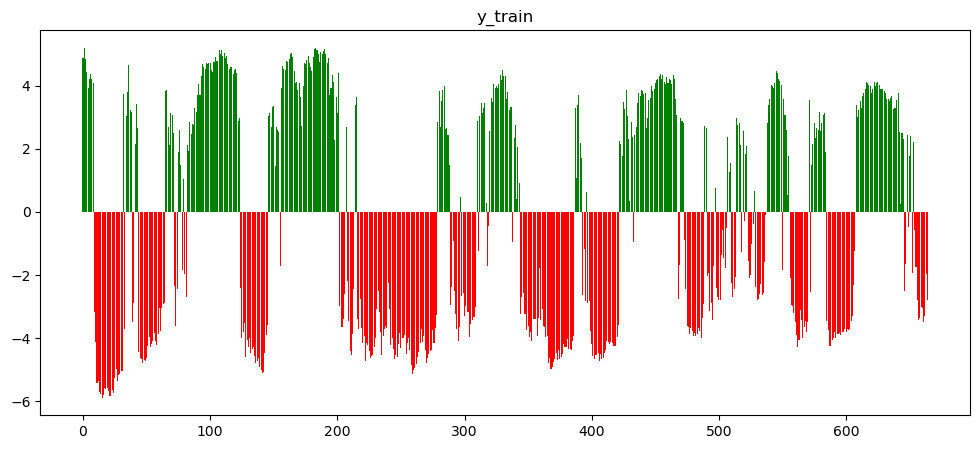

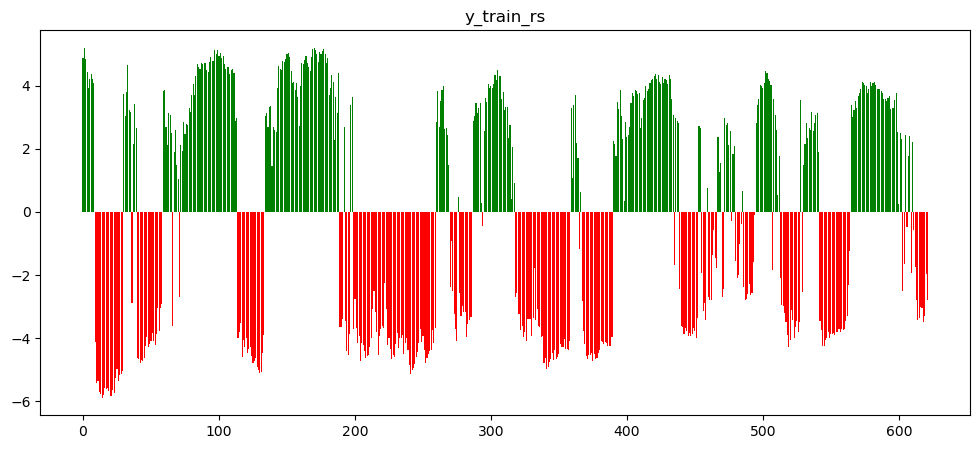

In [5]:
x_train_rs, y_train_rs = undersampleSeriesDataTomekBySign(x_train, y_train)
print(f"positive y_train_rs: {len(y_train_rs[y_train_rs > 0])}")
print(f"negative y_train_rs: {len(y_train_rs[y_train_rs < 0])}")

plt.figure(figsize=(12,5))
plotBarColoredSign(y_train.reshape(-1))
plt.title('y_train')

plt.figure(figsize=(12,5))
plotBarColoredSign(y_train_rs.reshape(-1))
plt.title('y_train_rs')

positive y_test_rs: 124
negative y_test_rs: 124


Text(0.5, 1.0, 'y_test_rs')

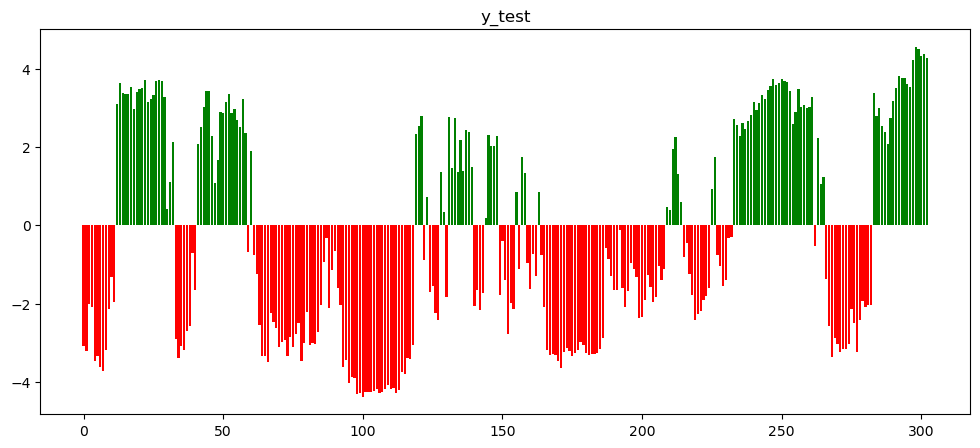

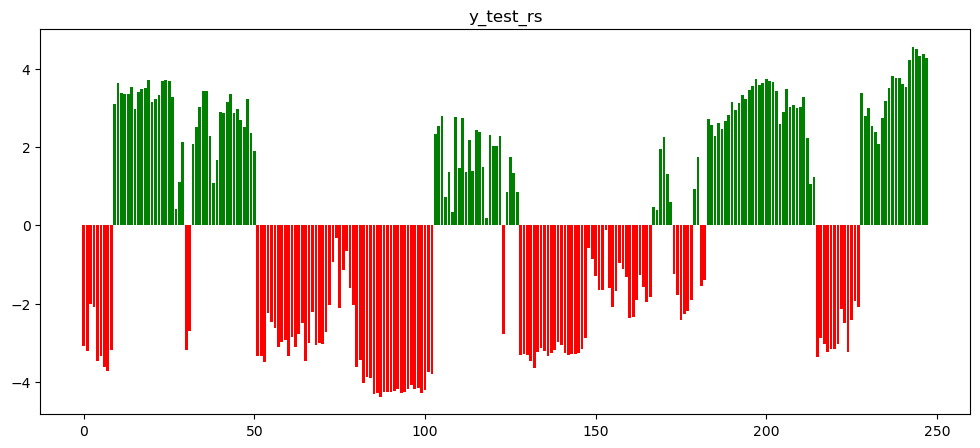

In [6]:
x_test_rs, y_test_rs = undersampleSeriesDataTomekBySign(x_test, y_test)

print(f"positive y_test_rs: {len(y_test_rs[y_test_rs > 0])}")
print(f"negative y_test_rs: {len(y_test_rs[y_test_rs < 0])}")

plt.figure(figsize=(12,5))
plotBarColoredSign(y_test.reshape(-1))
plt.title('y_test')

plt.figure(figsize=(12,5))
plotBarColoredSign(y_test_rs.reshape(-1))
plt.title('y_test_rs')

## Scaling for each sign

To scale +ve or -ve PoF data to match each other.

In [ ]:
def rescaleOneValue(v, y_pos_scale, y_neg_scale):
  if v > 0:
    return v / (y_pos_scale)
  else:
    return v / (y_neg_scale)

def rescaling(y):
  y_pos_mean = np.mean(y[y>0])
  y_neg_mean = -np.mean(y[y<0])
  print(f"y_pos_mean: {y_pos_mean}")
  print(f"y_neg_mean: {y_neg_mean}")
  scale_target = min(y_pos_mean, y_neg_mean)
  print(f"scale_target: {scale_target}")
  y_pos_scale = y_pos_mean / scale_target
  y_neg_scale = y_neg_mean / scale_target
  return np.array([rescaleOneValue(v, y_pos_scale, y_neg_scale) for v in y])

y_train_scaled = rescaling(y_train_rs)
y_test_scaled = rescaling(y_test_rs)

print(f"mean of y_train_scaled: {np.round(np.mean(y_train_scaled), 2)}")
print(f"mean of y_test_scaled: {np.round(np.mean(y_test_scaled), 2)}")

# plt.figure(figsize=(12,5))
# plotBarColoredSign(y_train_rs.reshape(-1))
# plt.title('y_train_rs')

# plt.figure(figsize=(12,5))
# plotBarColoredSign(y_train_scaled.reshape(-1))
# plt.title('y_train_scaled')

# plt.figure(figsize=(12,5))
# plotBarColoredSign(y_test_rs.reshape(-1))
# plt.title('y_test_rs')

# plt.figure(figsize=(12,5))
# plotBarColoredSign(y_test_scaled.reshape(-1))
# plt.title('y_test_scaled')

y_pos_mean: 3.4938657860567623
y_neg_mean: 3.7503192019669
scale_target: 3.4938657860567623
y_pos_mean: 2.6817229422782285
y_neg_mean: 2.79059415464533
scale_target: 2.6817229422782285
mean of y_train_scaled: -0.0
mean of y_test_scaled: 0.0


## Shuffling

In [ ]:
train_dataset, test_dataset = prepareDataSetFromArray(x_train_rs, y_train_scaled.reshape(-1, 1), x_test_rs, y_test_scaled.reshape(-1, 1), shuffle=True) 

## [Model1] ARIMA Model training

In [ ]:
neuronCount = 256

# Create input to stacks
input = layers.Input(shape=(windowSize,1), name="stack_input")
x = input
x = tf.keras.layers.multiply([x, np.array([1./input_scale])])

tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neuronCount, return_sequences=True)),

x = tf.keras.layers.LSTM(neuronCount, activation='relu', return_sequences=True)(x)
x = tf.keras.layers.LSTM(round(neuronCount/2), activation='relu', return_sequences=True)(x)

residual = tf.keras.layers.LSTM(round(neuronCount/2), return_sequences=True)(input)  # Skip connection
x = tf.keras.layers.Add()([x, residual])  # Adding the residual connection

x = tf.keras.layers.LSTM(round(neuronCount/4), activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='tanh')(x)
x = tf.keras.layers.Dense(1, activation='tanh')(x)
x = tf.keras.layers.multiply([x, np.array([output_scale])])

model1 = tf.keras.Model(inputs=input, outputs=x)
model1.compile(loss="mse",
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=["mse"])
# model1.summary()


Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 17: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 22: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch: 7.

Epoch 27: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 27: early stopping
8/8 [==============================] - 1s 48ms/step - loss: 7.9281 - mse: 7.9281
loss: 2.8156803375462616
corr: 0.2531267671089153


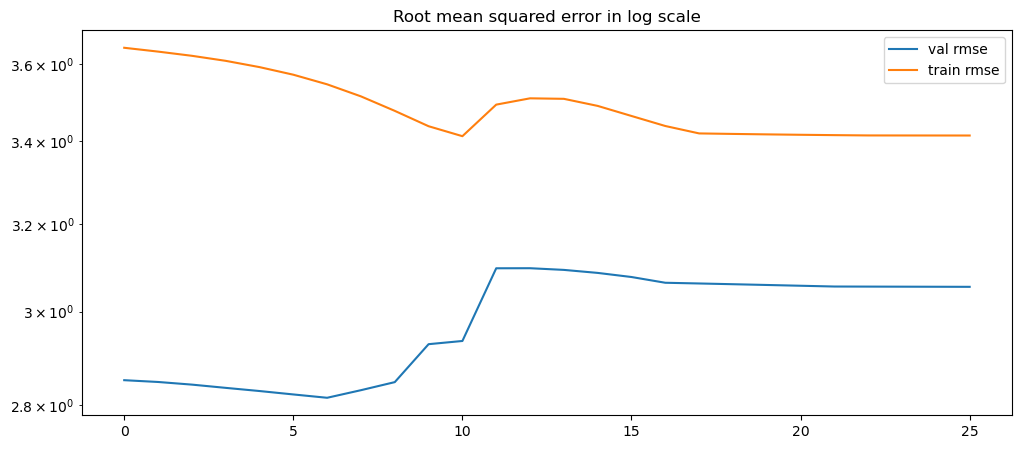

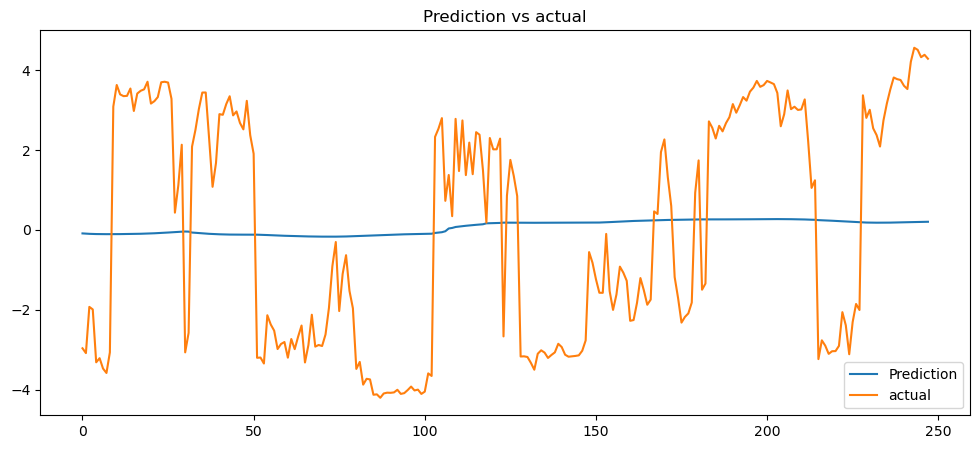

In [135]:
history1, rmse1, corr1 = standardTrainingAndReport(model1, x_test_rs, y_test_scaled, train_dataset, test_dataset)


Epoch 6: ReduceLROnPlateau reducing learning rate to 2.9999999242136257e-06.

Epoch 11: ReduceLROnPlateau reducing learning rate to 2.9999998787388907e-07.

Epoch 16: ReduceLROnPlateau reducing learning rate to 2.999999821895472e-08.
Restoring model weights from the end of the best epoch: 1.

Epoch 21: ReduceLROnPlateau reducing learning rate to 2.999999892949745e-09.
Epoch 21: early stopping
8/8 [==============================] - 1s 57ms/step - loss: 7.9343 - mse: 7.9343
loss: 2.816786910957146
corr: 0.2534316068093001


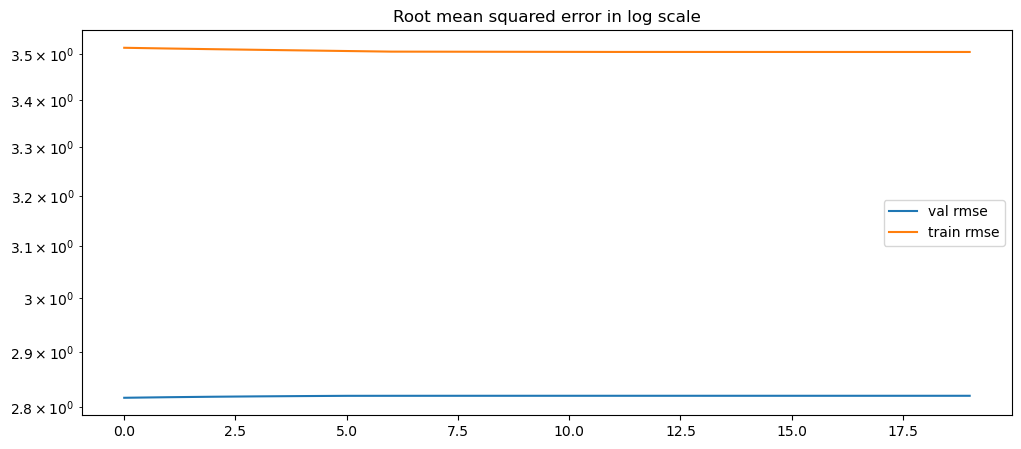

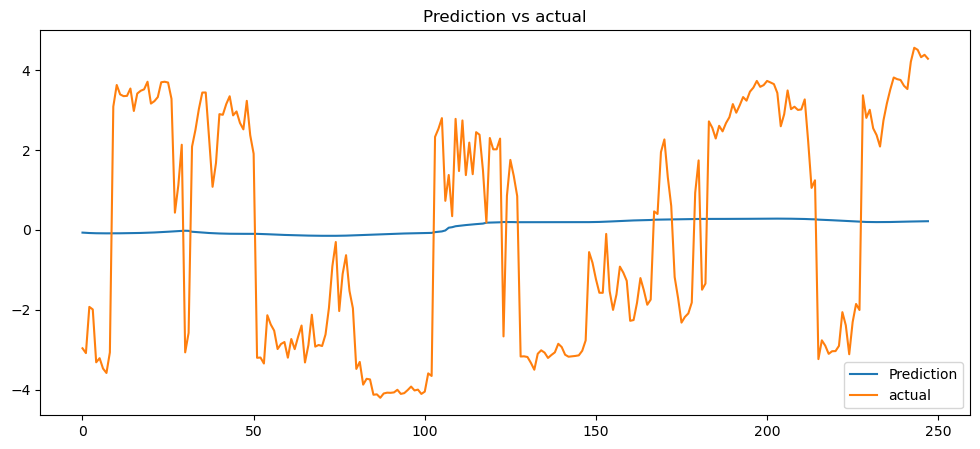

In [136]:

model1.compile(loss="mse",
              optimizer=tf.keras.optimizers.Adam(0.00003),
              metrics=["mse"])

history1, rmse1, corr1 = standardTrainingAndReport(model1, x_test_rs, y_test_scaled, train_dataset, test_dataset)

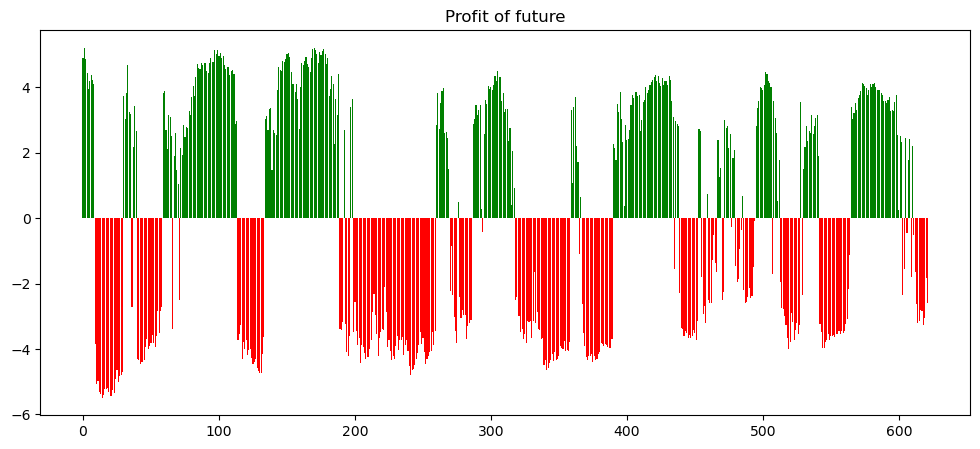

-5.4899488727109285 5.199993149092259


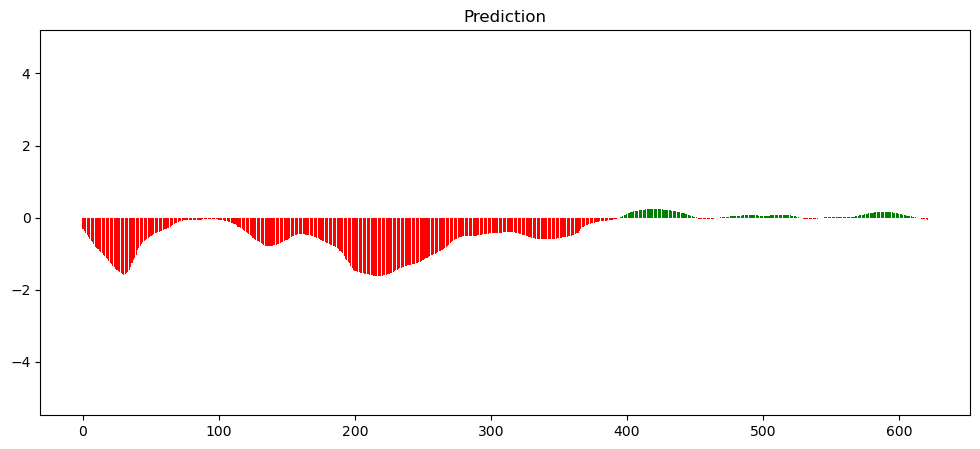

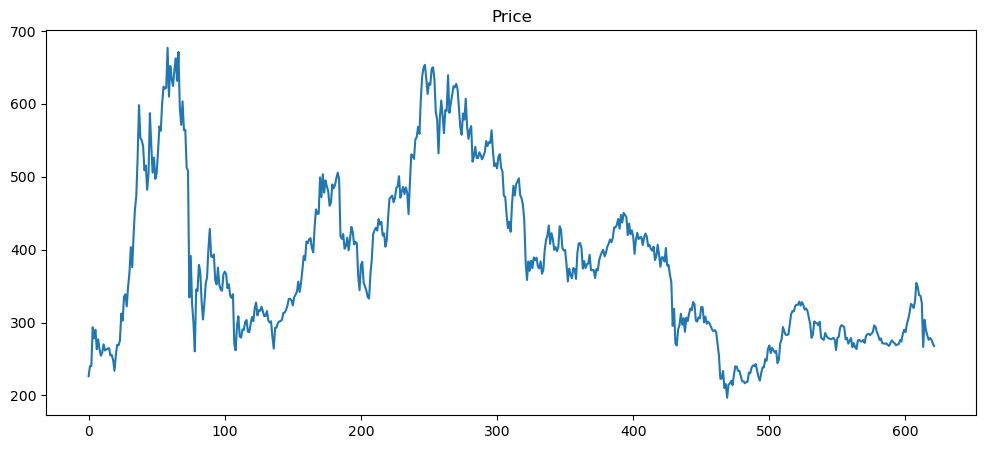

In [137]:
# check the training performance

plt.figure(figsize=(12, 5))
plotBarColoredSign(y_train_scaled.reshape(-1))
plt.title('Profit of future')
plt.show()

y_test_min = np.min(y_train_scaled.reshape(-1))
y_test_max = np.max(y_train_scaled.reshape(-1))
print(y_test_min, y_test_max)

prediction = model1.predict(x_train_rs)
prediction = prediction.reshape(-1)
plt.figure(figsize=(12, 5))
plotBarColoredSign(prediction.reshape(-1))
plt.title('Prediction')
plt.ylim(y_test_min, y_test_max)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(input_data[0:len(x_train_rs)].reshape(-1))
plt.title('Price')
plt.show()

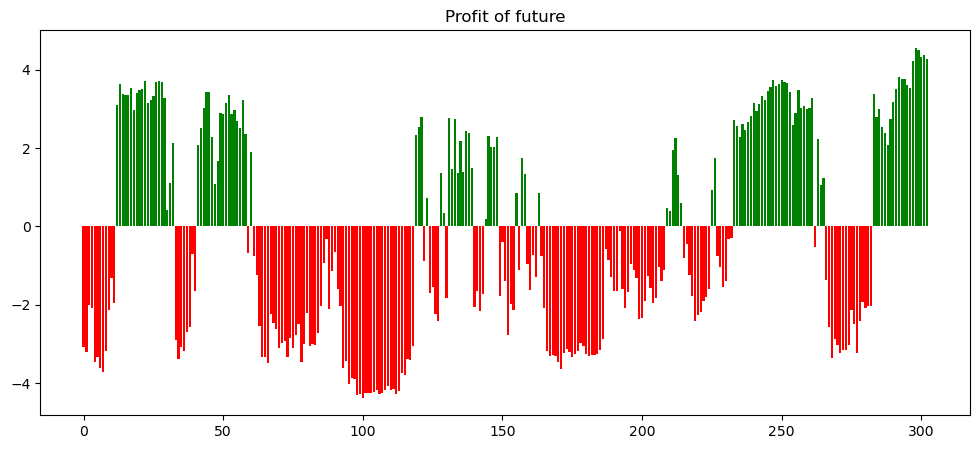

-4.368688070234701 4.555559685434757


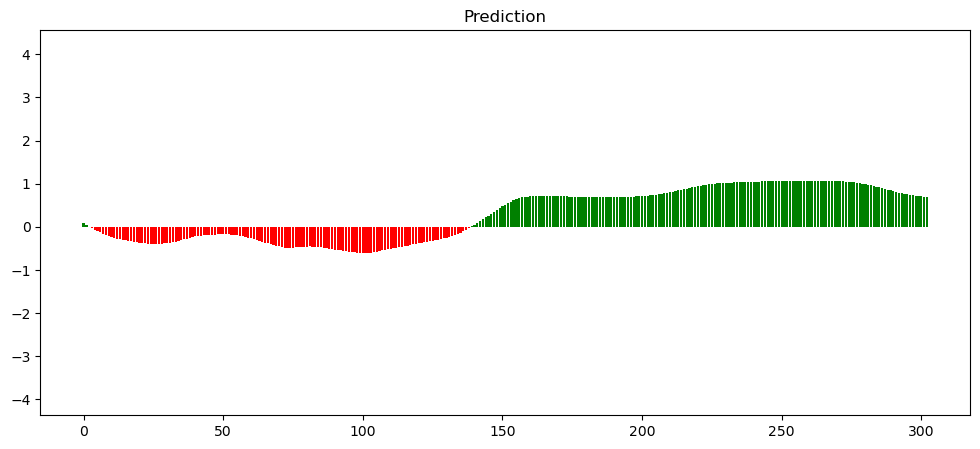

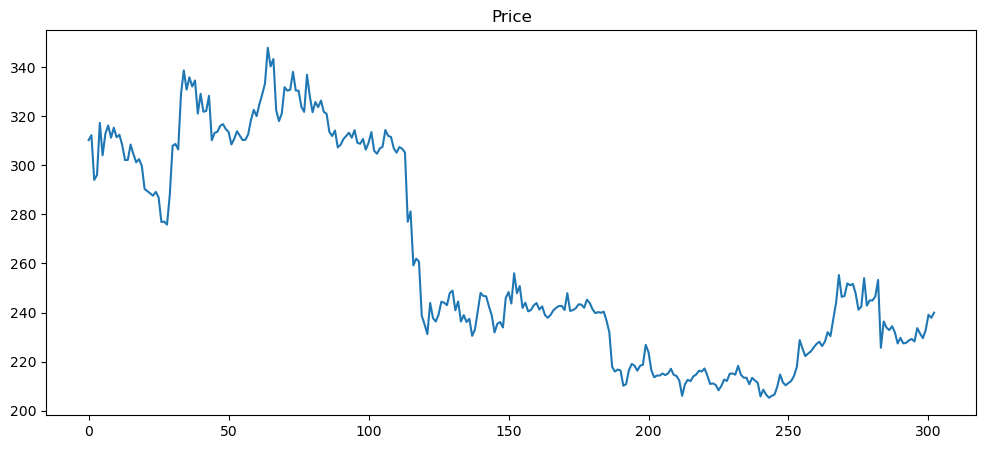

In [ ]:
# check the testing performance

plt.figure(figsize=(12, 5))
plotBarColoredSign(y_test.reshape(-1))
plt.title('Profit of future')
plt.show()

y_test_min = np.min(y_test.reshape(-1))
y_test_max = np.max(y_test.reshape(-1))
print(y_test_min, y_test_max)

prediction = model1.predict(x_test)
prediction = prediction.reshape(-1)
plt.figure(figsize=(12, 5))
plotBarColoredSign(prediction.reshape(-1))
plt.title('Prediction')
plt.ylim(y_test_min, y_test_max)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(input_data[-len(x_test):].reshape(-1))
plt.title('Price')
plt.show()

## [Model2] N-BEAT


Epoch 17: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 25: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 30: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 35: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Restoring model weights from the end of the best epoch: 20.

Epoch 40: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 40: early stopping
8/8 [==============================] - 2s 26ms/step - loss: 7.7264 - mse: 7.7264
loss: 2.7796491666383916
corr: 0.25163385346012934


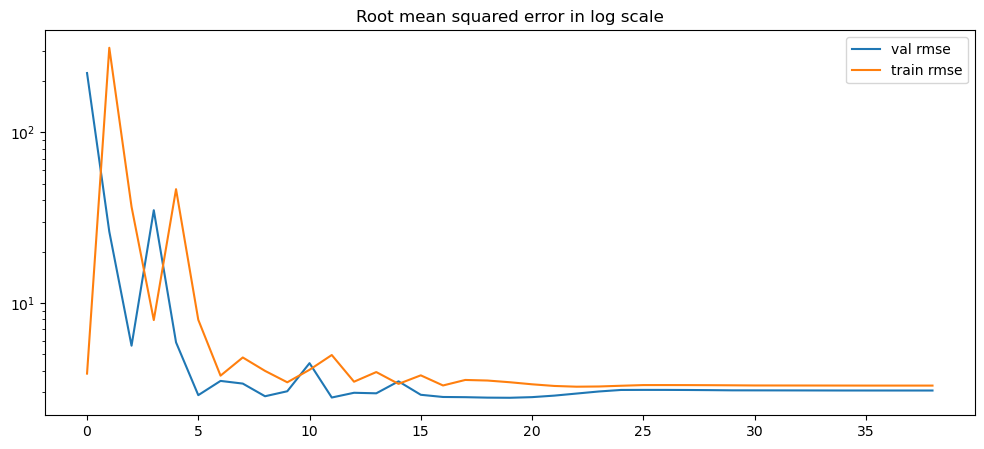

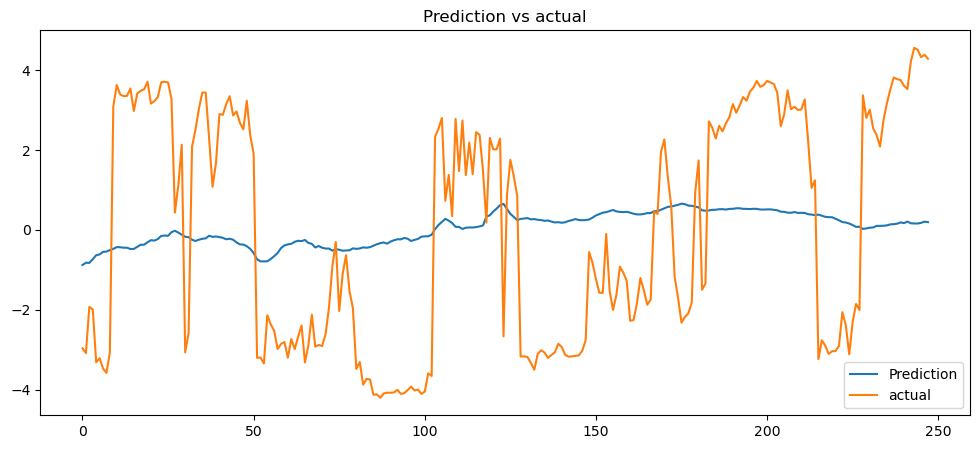

In [110]:
train_dataset, test_dataset = prepareDataSetFromArray(x_train_rs, y_train_scaled, x_test_rs, y_test_scaled, shuffle=True)

nbeatNeuronCount = 512
nBeatLayerCount = 4
nBeatStackCount = 30

input = layers.Input(shape=(windowSize), name="stack_input")
x = input
x = tf.keras.layers.multiply([x, np.array([1./input_scale])])
x = buildNBeatLayers(windowSize, windowSize+1, 1, nbeatNeuronCount, nBeatLayerCount, nBeatStackCount, x)
x = tf.keras.layers.multiply([x, np.array([output_scale])])

model2 = tf.keras.Model(inputs=input, outputs=x)
model2.compile(loss="mse",
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=["mse"])

history2, rmse2, corr2 = standardTrainingAndReport(model2, x_test_rs, y_test_scaled, train_dataset, test_dataset)

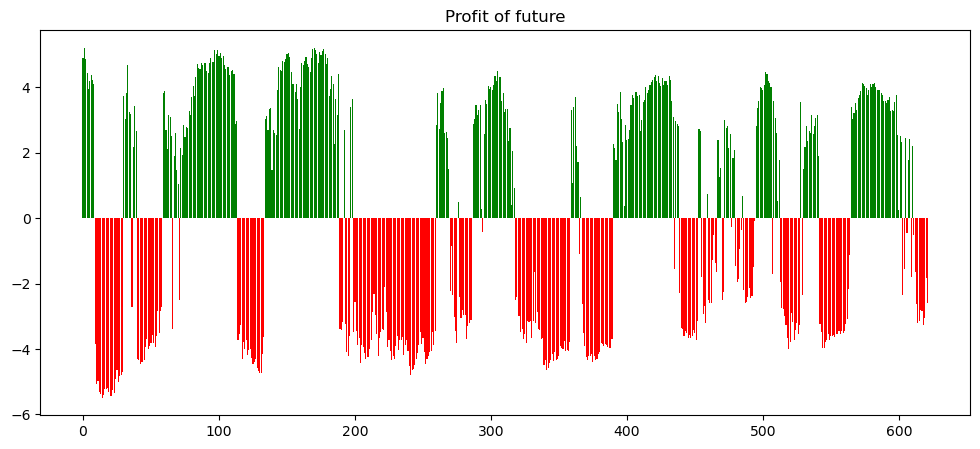

-5.4899488727109285 5.199993149092259


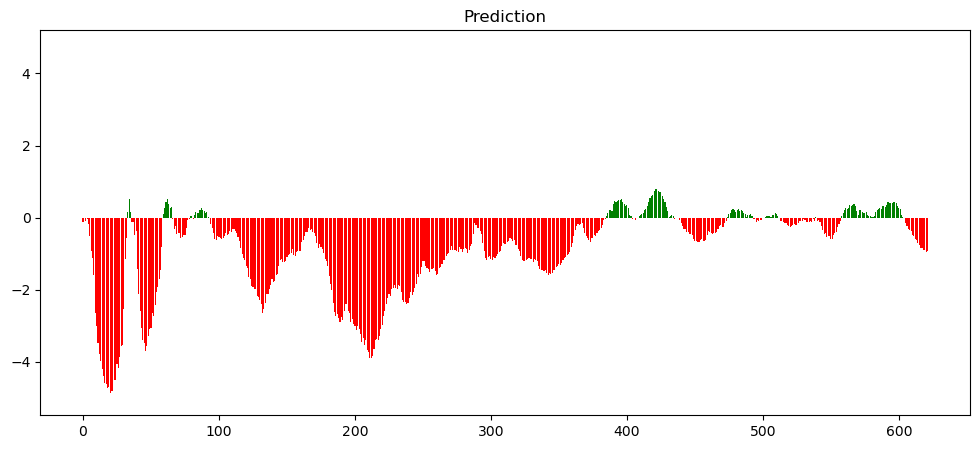

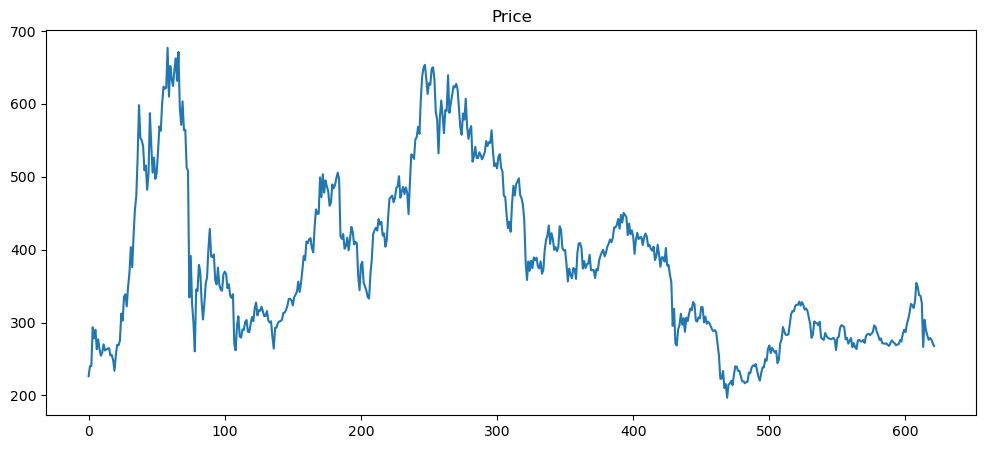

In [117]:
# check the training performance

plt.figure(figsize=(12, 5))
plotBarColoredSign(y_train_scaled.reshape(-1))
plt.title('Profit of future')
plt.show()

y_test_min = np.min(y_train_scaled.reshape(-1))
y_test_max = np.max(y_train_scaled.reshape(-1))
print(y_test_min, y_test_max)

prediction = model2.predict(x_train_rs)
prediction = prediction.reshape(-1)
plt.figure(figsize=(12, 5))
plotBarColoredSign(prediction.reshape(-1))
plt.title('Prediction')
plt.ylim(y_test_min, y_test_max)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(input_data[0:len(x_train_rs)].reshape(-1))
plt.title('Price')
plt.show()

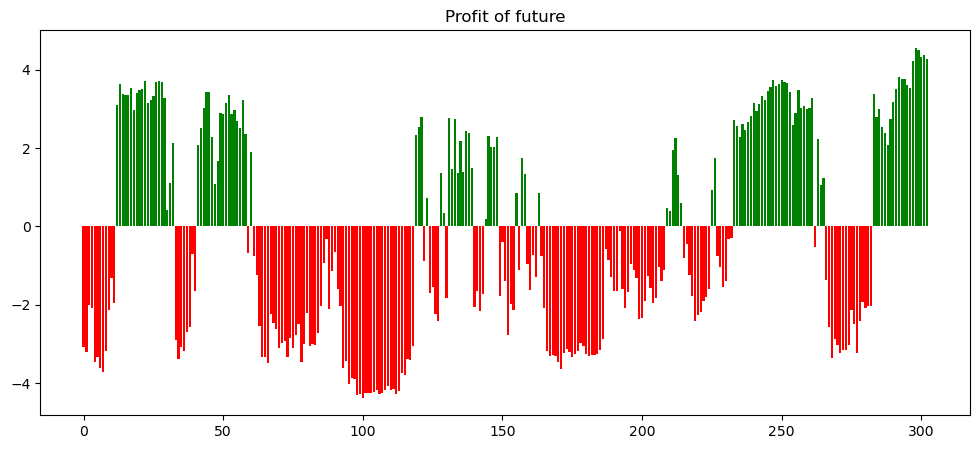

-4.368688070234701 4.555559685434757


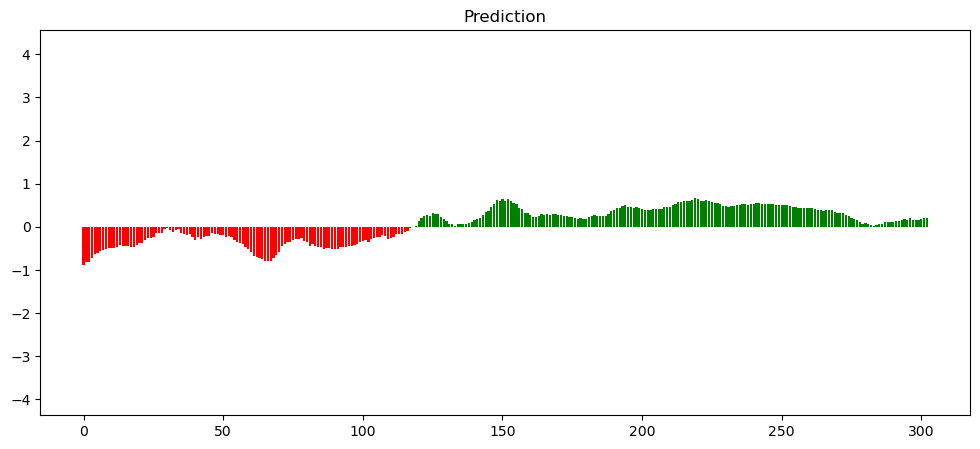

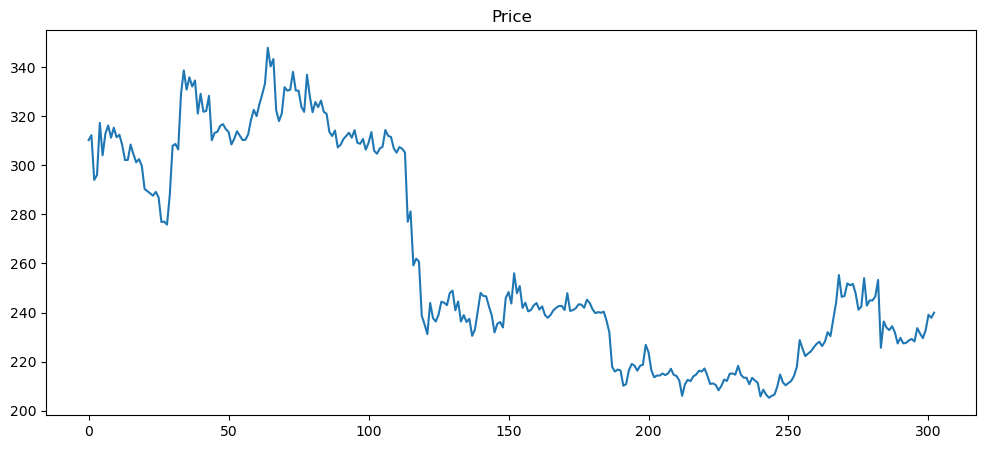

In [118]:
# check the testing performance

plt.figure(figsize=(12, 5))
plotBarColoredSign(y_test.reshape(-1))
plt.title('Profit of future')
plt.show()

y_test_min = np.min(y_test.reshape(-1))
y_test_max = np.max(y_test.reshape(-1))
print(y_test_min, y_test_max)

prediction = model2.predict(x_test)
prediction = prediction.reshape(-1)
plt.figure(figsize=(12, 5))
plotBarColoredSign(prediction.reshape(-1))
plt.title('Prediction')
plt.ylim(y_test_min, y_test_max)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(input_data[-len(x_test):].reshape(-1))
plt.title('Price')
plt.show()